In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rl-dataset/priceData.xls
/kaggle/input/rl-dataset/BTCUSDT.xlsx
/kaggle/input/rl-dataset/Visualization.py
/kaggle/input/rl-dataset/exports.xlsx
/kaggle/input/rl-dataset/priceData.csv
/kaggle/input/rl-dataset/priceData.xlsx
/kaggle/input/rl-dataset/pandas_positioning.xlsx
/kaggle/input/btc-usd-full-dataset/btc_3m.csv
/kaggle/input/btc-usd-full-dataset/btc_1h.csv
/kaggle/input/btc-usd-full-dataset/btc_15m.csv
/kaggle/input/btc-usd-full-dataset/btc_30m.csv
/kaggle/input/btc-usd-full-dataset/btc_4h.csv
/kaggle/input/btc-usd-full-dataset/btc_6h.csv
/kaggle/input/btc-usd-full-dataset/btc_2h.csv
/kaggle/input/btc-usd-full-dataset/btc_5m.csv
/kaggle/input/models/model_t-dqn_GOOG_10
/kaggle/input/models/model_double-dqn_GOOG_50
/kaggle/input/models/model_dqn_GOOG_50


# Method One : Using DQN and Double DQN

In [3]:
import random

from collections import deque

import numpy as np
import tensorflow as tf
import keras.backend as K

from keras.models import Sequential
from keras.models import load_model, clone_model
from keras.layers import Dense
from keras.optimizers import Adam


def huber_loss(y_true, y_pred, clip_delta=1.0):
    """Huber loss - Custom Loss Function for Q Learning

    Links: 	https://en.wikipedia.org/wiki/Huber_loss
            https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
    """
    error = y_true - y_pred
    cond = K.abs(error) <= clip_delta
    squared_loss = 0.5 * K.square(error)
    quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
    return K.mean(tf.where(cond, squared_loss, quadratic_loss))


class Agent:
    """ Stock Trading Bot """

    def __init__(self, state_size, strategy="t-dqn", reset_every=1000, pretrained=False, model_name=None):
        self.strategy = strategy

        # agent config
        self.state_size = state_size    	# normalized previous days
        self.action_size = 3           		# [sit, buy, sell]
        self.model_name = model_name
        self.inventory = []
        self.memory = deque(maxlen=10000)
        self.first_iter = True

        # model config
        self.model_name = model_name
        self.gamma = 0.95 # affinity for long term reward
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.loss = huber_loss
        self.custom_objects = {"huber_loss": huber_loss}  # important for loading the model from memory
        self.optimizer = Adam(lr=self.learning_rate)

        if pretrained and self.model_name is not None:
            self.model = self.load()
        else:
            self.model = self._model()

        # strategy config
        if self.strategy in ["t-dqn", "double-dqn"]:
            self.n_iter = 1
            self.reset_every = reset_every

            # target network
            self.target_model = clone_model(self.model)
            self.target_model.set_weights(self.model.get_weights())

    def _model(self):
        """Creates the model
        """
        model = Sequential()
        model.add(Dense(units=128, activation="relu", input_dim=self.state_size))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=256, activation="relu"))
        model.add(Dense(units=128, activation="relu"))
        model.add(Dense(units=self.action_size))

        model.compile(loss=self.loss, optimizer=self.optimizer)
        return model

    def remember(self, state, action, reward, next_state, done):
        """Adds relevant data to memory
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, is_eval=False):
        """Take action from given possible set of actions
        """
        # take random action in order to diversify experience at the beginning
        if not is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)

        if self.first_iter:
            self.first_iter = False
            return 1 # make a definite buy on the first iter

        action_probs = self.model.predict(state)
        return np.argmax(action_probs[0])

    def train_experience_replay(self, batch_size):
        """Train on previous experiences in memory
        """
        mini_batch = random.sample(self.memory, batch_size)
        X_train, y_train = [], []
        
        # DQN
        if self.strategy == "dqn":
            for state, action, reward, next_state, done in mini_batch:
                if done:
                    target = reward
                else:
                    # approximate deep q-learning equation
                    target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

                # estimate q-values based on current state
                q_values = self.model.predict(state)
                # update the target for current action based on discounted reward
                q_values[0][action] = target

                X_train.append(state[0])
                y_train.append(q_values[0])

        # DQN with fixed targets
        elif self.strategy == "t-dqn":
            if self.n_iter % self.reset_every == 0:
                # reset target model weights
                self.target_model.set_weights(self.model.get_weights())

            for state, action, reward, next_state, done in mini_batch:
                if done:
                    target = reward
                else:
                    # approximate deep q-learning equation with fixed targets
                    target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])

                # estimate q-values based on current state
                q_values = self.model.predict(state)
                # update the target for current action based on discounted reward
                q_values[0][action] = target

                X_train.append(state[0])
                y_train.append(q_values[0])

        # Double DQN
        elif self.strategy == "double-dqn":
            if self.n_iter % self.reset_every == 0:
                # reset target model weights
                self.target_model.set_weights(self.model.get_weights())

            for state, action, reward, next_state, done in mini_batch:
                if done:
                    target = reward
                else:
                    # approximate double deep q-learning equation
                    target = reward + self.gamma * self.target_model.predict(next_state)[0][np.argmax(self.model.predict(next_state)[0])]

                # estimate q-values based on current state
                q_values = self.model.predict(state)
                # update the target for current action based on discounted reward
                q_values[0][action] = target

                X_train.append(state[0])
                y_train.append(q_values[0])
                
        else:
            raise NotImplementedError()

        # update q-function parameters based on huber loss gradient
        loss = self.model.fit(
            np.array(X_train), np.array(y_train),
            epochs=1, verbose=0
        ).history["loss"][0]

        # as the training goes on we want the agent to
        # make less random and more optimal decisions
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss

    def save(self, episode):
        self.model.save("models/{}_{}".format(self.model_name, episode))

    def load(self):
        return load_model("models/" + self.model_name, custom_objects=self.custom_objects)

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
data_path = '/kaggle/input/btc-usd-full-dataset/btc_30m.csv'
btc_data = pd.read_csv(data_path)

# Data preprocessing steps
# Example: Normalize the 'close' prices
scaler = MinMaxScaler()
btc_data['close'] = scaler.fit_transform(btc_data['close'].values.reshape(-1,1))

# Display the first few rows of the processed data
btc_data.head()


,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,0.158158,221.752443
1,2018-01-01 06:00:00,13500.00,13690.87,13450.00,0.158278,221.603756
2,2018-01-01 06:30:00,13528.99,13595.89,13402.28,0.158752,160.399291
3,2018-01-01 07:00:00,13559.99,13559.99,13155.38,0.153299,223.297715
4,2018-01-01 07:30:00,13203.00,13411.76,13202.03,0.153634,203.728509


Episode: 0, Total Reward: -0.14674715144908296
Episode: 1, Total Reward: 0.17167527512494318
Episode: 2, Total Reward: 0.416471019887687
Episode: 3, Total Reward: -0.04608119374422559
Episode: 4, Total Reward: -0.20786577953771795
Episode: 5, Total Reward: 0.36846625043418363
Episode: 6, Total Reward: -0.1501545367700446
Episode: 7, Total Reward: 0.056254469835168575
Episode: 8, Total Reward: 0.11826897432616007
Episode: 9, Total Reward: -0.760168769977751
Episode: 10, Total Reward: 0.5041847280339294
Episode: 11, Total Reward: -0.11180506951481683
Episode: 12, Total Reward: -0.3162758364491649
Episode: 13, Total Reward: 0.6790523170434004
Episode: 14, Total Reward: -0.33486469898705107
Episode: 15, Total Reward: -0.5214516955358339
Episode: 16, Total Reward: -0.33530752007664194
Episode: 17, Total Reward: -0.7974306600829504
Episode: 18, Total Reward: -0.2552690210675314
Episode: 19, Total Reward: 0.010873174756845128
Episode: 20, Total Reward: 0.10521438253570536
Episode: 21, Total R

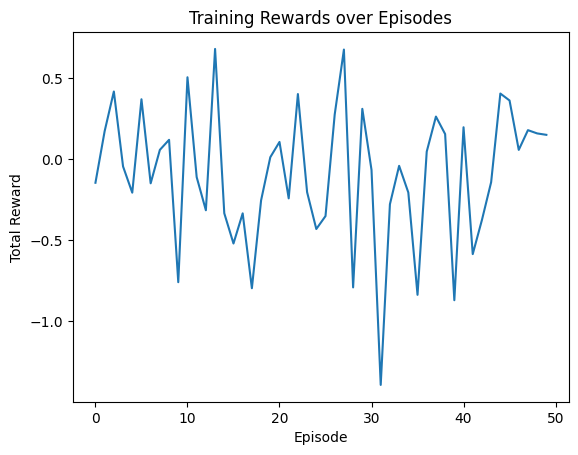

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

# Simple Trading Environment
class TradingEnv:
    def __init__(self, data, window_size=10):
        self.data = data
        self.window_size = window_size
        self.reset()

    def reset(self):
        self.current_step = random.randint(self.window_size, len(self.data) - 1)
        self.done = False
        return self._get_state()

    def _get_state(self):
        return self.data['close'][self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        # Assuming action is 0 (sell), 1 (hold), 2 (buy)
        reward = 0
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True
        next_state = self._get_state()

        # Simple reward function: price change times action (buy: +1, sell: -1)
        if action == 2:
            reward = self.data['close'][self.current_step] - self.data['close'][self.current_step - 1]
        elif action == 0:
            reward = self.data['close'][self.current_step - 1] - self.data['close'][self.current_step]

        return next_state, reward, self.done, {}

# Update the training loop
env = TradingEnv(btc_data, window_size=10)
num_episodes = 50
rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = random.choice([0, 1, 2])  # Random action for demonstration
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
    rewards.append(total_reward)
    print(f"Episode: {episode}, Total Reward: {total_reward}")

# Visualization of training results
plt.plot(rewards)
plt.title("Training Rewards over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

In [5]:
import os
import math
import logging

import numpy as np


def sigmoid(x):
    """Performs sigmoid operation
    """
    try:
        if x < 0:
            return 1 - 1 / (1 + math.exp(x))
        return 1 / (1 + math.exp(-x))
    except Exception as err:
        print("Error in sigmoid: " + err)


def get_state(data, t, n_days):
    """Returns an n-day state representation ending at time t
    """
    d = t - n_days + 1
    block = data[d: t + 1] if d >= 0 else -d * [data[0]] + data[0: t + 1]  # pad with t0
    res = []
    for i in range(n_days - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

In [6]:
import os
import math
import logging

import pandas as pd
import numpy as np

import keras.backend as K


# Formats Position
format_position = lambda price: ('-$' if price < 0 else '+$') + '{0:.2f}'.format(abs(price))


# Formats Currency
format_currency = lambda price: '${0:.2f}'.format(abs(price))


def show_train_result(result, val_position, initial_offset):
    """ Displays training results
    """
    if val_position == initial_offset or val_position == 0.0:
        logging.info('Episode {}/{} - Train Position: {}  Val Position: USELESS  Train Loss: {:.4f}'
                     .format(result[0], result[1], format_position(result[2]), result[3]))
    else:
        logging.info('Episode {}/{} - Train Position: {}  Val Position: {}  Train Loss: {:.4f})'
                     .format(result[0], result[1], format_position(result[2]), format_position(val_position), result[3],))


def show_eval_result(model_name, profit, initial_offset):
    """ Displays eval results
    """
    if profit == initial_offset or profit == 0.0:
        logging.info('{}: USELESS\n'.format(model_name))
    else:
        logging.info('{}: {}\n'.format(model_name, format_position(profit)))


def get_stock_data(stock_file):
    """Reads stock data from csv file
    """
    df = pd.read_csv(stock_file)
    return list(df['Adj Close'])


def switch_k_backend_device():
    """ Switches `keras` backend from GPU to CPU if required.

    Faster computation on CPU (if using tensorflow-gpu).
    """
    if K.backend() == "tensorflow":
        logging.debug("switching to TensorFlow for CPU")
        os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [7]:
import os
import logging

import numpy as np

from tqdm import tqdm

'''from .utils import (
    format_currency,
    format_position
)
from .ops import (
    get_state
)
'''


def train_model(agent, episode, data, ep_count=100, batch_size=32, window_size=10):
    total_profit = 0
    data_length = len(data) - 1

    agent.inventory = []
    avg_loss = []

    state = get_state(data, 0, window_size + 1)

    for t in tqdm(range(data_length), total=data_length, leave=True, desc='Episode {}/{}'.format(episode, ep_count)):        
        reward = 0
        next_state = get_state(data, t + 1, window_size + 1)

        # select an action
        action = agent.act(state)

        # BUY
        if action == 1:
            agent.inventory.append(data[t])

        # SELL
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            delta = data[t] - bought_price
            reward = delta #max(delta, 0)
            total_profit += delta

        # HOLD
        else:
            pass

        done = (t == data_length - 1)
        agent.remember(state, action, reward, next_state, done)

        if len(agent.memory) > batch_size:
            loss = agent.train_experience_replay(batch_size)
            avg_loss.append(loss)

        state = next_state

    if episode % 10 == 0:
        agent.save(episode)

    return (episode, ep_count, total_profit, np.mean(np.array(avg_loss)))


def evaluate_model(agent, data, window_size, debug):
    total_profit = 0
    data_length = len(data) - 1

    history = []
    agent.inventory = []
    
    state = get_state(data, 0, window_size + 1)

    for t in range(data_length):        
        reward = 0
        next_state = get_state(data, t + 1, window_size + 1)
        
        # select an action
        action = agent.act(state, is_eval=True)

        # BUY
        if action == 1:
            agent.inventory.append(data[t])

            history.append((data[t], "BUY"))
            if debug:
                logging.debug("Buy at: {}".format(format_currency(data[t])))
        
        # SELL
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            delta = data[t] - bought_price
            reward = delta #max(delta, 0)
            total_profit += delta

            history.append((data[t], "SELL"))
            if debug:
                logging.debug("Sell at: {} | Position: {}".format(
                    format_currency(data[t]), format_position(data[t] - bought_price)))
        # HOLD
        else:
            history.append((data[t], "HOLD"))

        done = (t == data_length - 1)
        agent.memory.append((state, action, reward, next_state, done))

        state = next_state
        if done:
            return total_profit, history

In [8]:
!pip install coloredlogs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.3 MB/s eta 0:00:00


In [8]:
"""
Script for evaluating Stock Trading Bot.

Usage:
  eval.py <eval-stock> [--window-size=<window-size>] [--model-name=<model-name>] [--debug]

Options:
  --window-size=<window-size>   Size of the n-day window stock data representation used as the feature vector. [default: 10]
  --model-name=<model-name>     Name of the pretrained model to use (will eval all models in `models/` if unspecified).
  --debug                       Specifies whether to use verbose logs during eval operation.
"""

import os
import coloredlogs

from docopt import docopt

'''from trading_bot.agent import Agent
from trading_bot.methods import evaluate_model
from trading_bot.utils import (
    get_stock_data,
    format_currency,
    format_position,
    show_eval_result,
    switch_k_backend_device
)
'''

def main(eval_stock, window_size, model_name, debug):
    """ Evaluates the stock trading bot.
    Please see https://arxiv.org/abs/1312.5602 for more details.

    Args: [python eval.py --help]
    """    
    data = get_stock_data(eval_stock)
    initial_offset = data[1] - data[0]

    # Single Model Evaluation
    if model_name is not None:
        agent = Agent(window_size, pretrained=True, model_name=model_name)
        profit, _ = evaluate_model(agent, data, window_size, debug)
        show_eval_result(model_name, profit, initial_offset)
        
    # Multiple Model Evaluation
    else:
        for model in os.listdir("models"):
            if os.path.isfile(os.path.join("models", model)):
                agent = Agent(window_size, pretrained=True, model_name=model)
                profit = evaluate_model(agent, data, window_size, debug)
                show_eval_result(model, profit, initial_offset)
                del agent


if __name__ == "__main__":
    args = docopt(__doc__)

    eval_stock = args["<eval-stock>"]
    window_size = int(args["--window-size"])
    model_name = args["--model-name"]
    debug = args["--debug"]

    coloredlogs.install(level="DEBUG")
    switch_k_backend_device()

    try:
        main(eval_stock, window_size, model_name, debug)
    except KeyboardInterrupt:
        print("Aborted")

DocoptLanguageError: "usage:" (case-insensitive) not found.

In [9]:
"""
Script for training Stock Trading Bot.

Usage:
  train.py <train-stock> <val-stock> [--strategy=<strategy>]
    [--window-size=<window-size>] [--batch-size=<batch-size>]
    [--episode-count=<episode-count>] [--model-name=<model-name>]
    [--pretrained] [--debug]

Options:
  --strategy=<strategy>             Q-learning strategy to use for training the network. Options:
                                      `dqn` i.e. Vanilla DQN,
                                      `t-dqn` i.e. DQN with fixed target distribution,
                                      `double-dqn` i.e. DQN with separate network for value estimation. [default: t-dqn]
  --window-size=<window-size>       Size of the n-day window stock data representation
                                    used as the feature vector. [default: 10]
  --batch-size=<batch-size>         Number of samples to train on in one mini-batch
                                    during training. [default: 32]
  --episode-count=<episode-count>   Number of trading episodes to use for training. [default: 50]
  --model-name=<model-name>         Name of the pretrained model to use. [default: model_debug]
  --pretrained                      Specifies whether to continue training a previously
                                    trained model (reads `model-name`).
  --debug                           Specifies whether to use verbose logs during eval operation.
"""

import logging
import coloredlogs

from docopt import docopt

'''from trading_bot.agent import Agent
from trading_bot.methods import train_model, evaluate_model
from trading_bot.utils import (
    get_stock_data,
    format_currency,
    format_position,
    show_train_result,
    switch_k_backend_device
)'''

def main(train_stock, val_stock, window_size, batch_size, ep_count,
         strategy="t-dqn", model_name="model_debug", pretrained=False,
         debug=False):
    """ Trains the stock trading bot using Deep Q-Learning.
    Please see https://arxiv.org/abs/1312.5602 for more details.

    Args: [python train.py --help]
    """
    agent = Agent(window_size, strategy=strategy, pretrained=pretrained, model_name=model_name)
    
    train_data = get_stock_data(train_stock)
    val_data = get_stock_data(val_stock)

    initial_offset = val_data[1] - val_data[0]

    for episode in range(1, ep_count + 1):
        train_result = train_model(agent, episode, train_data, ep_count=ep_count,
                                   batch_size=batch_size, window_size=window_size)
        val_result, _ = evaluate_model(agent, val_data, window_size, debug)
        show_train_result(train_result, val_result, initial_offset)


if __name__ == "__main__":
    args = docopt(__doc__)

    train_stock = args["<train-stock>"]
    val_stock = args["<val-stock>"]
    strategy = args["--strategy"]
    window_size = int(args["--window-size"])
    batch_size = int(args["--batch-size"])
    ep_count = int(args["--episode-count"])
    model_name = args["--model-name"]
    pretrained = args["--pretrained"]
    debug = args["--debug"]

    coloredlogs.install(level="DEBUG")
    switch_k_backend_device()

    try:
        main(train_stock, val_stock, window_size, batch_size,
             ep_count, strategy=strategy, model_name=model_name, 
             pretrained=pretrained, debug=debug)
    except KeyboardInterrupt:
        print("Aborted!")

DocoptLanguageError: "usage:" (case-insensitive) not found.

In [1]:
import pandas as pd
import numpy as np

import altair as alt
import seaborn as sns

In [8]:
model_name = 'model_dqn_GOOG_50'
test_stock = 'kaggle/input/btc-usd-full-dataset/btc_30m.csv'
window_size = 10
debug = True

agent = Agent(window_size, pretrained=True, model_name=model_name)

OSError: No file or directory found at models/model_dqn_GOOG_50

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the BTC-USD dataset
data_path = '/mnt/data/btc_30m.csv'
btc_data = pd.read_csv(data_path)

# Preprocess the data
# Normalize the 'close' prices (as an example of preprocessing)
scaler = MinMaxScaler()
btc_data['close'] = scaler.fit_transform(btc_data['close'].values.reshape(-1,1))

# Display the first few rows of the processed data
btc_data.head()


In [ ]:
# read csv into dataframe
df = pd.read_csv(test_stock)
# filter out the desired features
df = df[['Date', 'Adj Close']]
# rename feature column names
df = df.rename(columns={'Adj Close': 'actual', 'Date': 'date'})
# convert dates from object to DateTime type
dates = df['date']
dates = pd.to_datetime(dates, infer_datetime_format=True)
df['date'] = dates

df.head()

In [ ]:
import logging
import coloredlogs

from trading_bot.utils import show_eval_result, switch_k_backend_device, get_stock_data
from trading_bot.methods import evaluate_model

coloredlogs.install(level='DEBUG')
switch_k_backend_device()

test_data = get_stock_data(test_stock)
initial_offset = test_data[1] - test_data[0]

test_result, history = evaluate_model(agent, test_data, window_size, debug)
show_eval_result(model_name, test_result, initial_offset)

In [ ]:
def visualize(df, history, title="trading session"):
    # add history to dataframe
    position = [history[0][0]] + [x[0] for x in history]
    actions = ['HOLD'] + [x[1] for x in history]
    df['position'] = position
    df['action'] = actions
    
    # specify y-axis scale for stock prices
    scale = alt.Scale(domain=(min(min(df['actual']), min(df['position'])) - 50, max(max(df['actual']), max(df['position'])) + 50), clamp=True)
    
    # plot a line chart for stock positions
    actual = alt.Chart(df).mark_line(
        color='green',
        opacity=0.5
    ).encode(
        x='date:T',
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale)
    ).interactive(
        bind_y=False
    )
    
    # plot the BUY and SELL actions as points
    points = alt.Chart(df).transform_filter(
        alt.datum.action != 'HOLD'
    ).mark_point(
        filled=True
    ).encode(
        x=alt.X('date:T', axis=alt.Axis(title='Date')),
        y=alt.Y('position', axis=alt.Axis(format='$.2f', title='Price'), scale=scale),
        color='action'
    ).interactive(bind_y=False)

    # merge the two charts
    chart = alt.layer(actual, points, title=title).properties(height=300, width=1000)
    
    return chart

In [ ]:
chart = visualize(df, history, title=test_stock)
chart

In [ ]:
# Load the trained model (adjust the model loading as necessary)
# model = load_model('path_to_trained_model')

# Prepare the BTC-USD data for model evaluation
# Example: Extract features required by the model from btc_data
# test_data = prepare_data_for_model(btc_data)

# Run the model evaluation
# Example (pseudo-code):
# evaluation_results = model.evaluate(test_data)

# Visualization of evaluation results
# Example: Plotting predicted vs actual prices, or profit/loss over time
import matplotlib.pyplot as plt

# Assuming evaluation_results contains predicted prices
# actual_prices = btc_data['close'][-len(evaluation_results):]
# predicted_prices = evaluation_results

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('BTC-USD: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Method 2: Dueling Deep Q Networks

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the BTC-USD dataset
data_path = '/kaggle/input/btc-usd-full-dataset/btc_30m.csv'
btc_data = pd.read_csv(data_path)

# Preprocess the data
# Normalize the 'close' prices (as an example of preprocessing)
scaler = MinMaxScaler()
btc_data['close'] = scaler.fit_transform(btc_data['close'].values.reshape(-1,1))

# Display the first few rows of the processed data
btc_data.head()

In [9]:
STATE_SPACE = 28
ACTION_SPACE = 3

ACTION_LOW = -1
ACTION_HIGH = 1

GAMMA = 0.9995
TAU = 1e-3
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 0.9

MEMORY_LEN = 10000
MEMORY_THRESH = 500
BATCH_SIZE = 200

LR_DQN = 5e-4

LEARN_AFTER = MEMORY_THRESH
LEARN_EVERY = 3
UPDATE_EVERY = 9

COST = 3e-4
CAPITAL = 100000
NEG_MUL = 2

In [10]:
class DataGetter:
  """
  The class for getting data for assets.
  """

  def __init__(self, asset="BTC-USD", start_date=None, end_date=None, freq="1d", 
               timeframes=[1, 2, 5, 10, 20, 40]):
    self.asset = asset
    self.sd = start_date
    self.ed = end_date
    self.freq = freq

    self.timeframes = timeframes
    self.getData()

    self.scaler = StandardScaler()
    self.scaler.fit(self.data[:, 1:])


  def getData(self):
    
    asset = self.asset  
    if self.sd is not None and self.ed is not None:
      df =  yf.download([asset], start=self.sd, end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, end=self.ed, interval=self.freq)
    elif self.sd is None and self.ed is not None:
      df =  yf.download([asset], end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], end=self.ed, interval=self.freq)
    elif self.sd is not None and self.ed is None:
      df =  yf.download([asset], start=self.sd, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, interval=self.freq)
    else:
      df = yf.download([asset], period="max", interval=self.freq)
      df_spy = yf.download(["BTC-USD"], interval=self.freq)
    
    # Reward - Not included in Observation Space.
    df["rf"] = df["Adj Close"].pct_change().shift(-1)

    # Returns and Trading Volume Changes
    for i in self.timeframes:
      df_spy[f"spy_ret-{i}"] = df_spy["Adj Close"].pct_change(i)
      df_spy[f"spy_v-{i}"] = df_spy["Volume"].pct_change(i)

      df[f"r-{i}"] = df["Adj Close"].pct_change(i)      
      df[f"v-{i}"] = df["Volume"].pct_change(i)
    
    # Volatility
    for i in [5, 10, 20, 40]:
      df[f'sig-{i}'] = np.log(1 + df["r-1"]).rolling(i).std()

    # Moving Average Convergence Divergence (MACD)
    df["macd_lmw"] = df["r-1"].ewm(span=26, adjust=False).mean()
    df["macd_smw"] = df["r-1"].ewm(span=12, adjust=False).mean()
    df["macd_bl"] = df["r-1"].ewm(span=9, adjust=False).mean()
    df["macd"] = df["macd_smw"] - df["macd_lmw"]

    # Relative Strength Indicator (RSI)
    rsi_lb = 5
    pos_gain = df["r-1"].where(df["r-1"] > 0, 0).ewm(rsi_lb).mean()
    neg_gain = df["r-1"].where(df["r-1"] < 0, 0).ewm(rsi_lb).mean()
    rs = np.abs(pos_gain/neg_gain)
    df["rsi"] = 100 * rs/(1 + rs)

    # Bollinger Bands
    bollinger_lback = 10
    df["bollinger"] = df["r-1"].ewm(bollinger_lback).mean()
    df["low_bollinger"] = df["bollinger"] - 2 * df["r-1"].rolling(bollinger_lback).std()
    df["high_bollinger"] = df["bollinger"] + 2 * df["r-1"].rolling(bollinger_lback).std()

    # SP500
    df = df.merge(df_spy[[f"spy_ret-{i}" for i in self.timeframes] + [f"spy_sig-{i}" for i in [5, 10, 20, 40]]], 
                  how="left", right_index=True, left_index=True)

    # Filtering
    for c in df.columns:
      df[c].interpolate('linear', limit_direction='both', inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    self.frame = df
    self.data = np.array(df.iloc[:, 6:])
    return


  def scaleData(self):
    self.scaled_data = self.scaler.fit_transform(self.data[:, 1:])
    return


  def __len__(self):
    return len(self.data)

class DataGetter:
  """
  The class for getting data for assets.
  """

  def __init__(self, asset="BTC-USD", start_date=None, end_date=None, freq="1d", 
               timeframes=[1, 2, 5, 10, 20, 40]):
    self.asset = asset
    self.sd = start_date
    self.ed = end_date
    self.freq = freq

    self.timeframes = timeframes
    self.getData()

    self.scaler = StandardScaler()
    self.scaler.fit(self.data[:, 1:])


  def getData(self):
    
    asset = self.asset  
    if self.sd is not None and self.ed is not None:
      df =  yf.download([asset], start=self.sd, end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, end=self.ed, interval=self.freq)
    elif self.sd is None and self.ed is not None:
      df =  yf.download([asset], end=self.ed, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], end=self.ed, interval=self.freq)
    elif self.sd is not None and self.ed is None:
      df =  yf.download([asset], start=self.sd, interval=self.freq)
      df_spy = yf.download(["BTC-USD"], start=self.sd, interval=self.freq)
    else:
      df = yf.download([asset], period="max", interval=self.freq)
      df_spy = yf.download(["BTC-USD"], interval=self.freq)
    
    # Reward - Not included in Observation Space.
    df["rf"] = df["Adj Close"].pct_change().shift(-1)

    # Returns and Trading Volume Changes
    for i in self.timeframes:
      df_spy[f"spy_ret-{i}"] = df_spy["Adj Close"].pct_change(i)
      df_spy[f"spy_v-{i}"] = df_spy["Volume"].pct_change(i)

      df[f"r-{i}"] = df["Adj Close"].pct_change(i)      
      df[f"v-{i}"] = df["Volume"].pct_change(i)
    
    # Volatility
    for i in [5, 10, 20, 40]:
      df[f'sig-{i}'] = np.log(1 + df["r-1"]).rolling(i).std()

    # Moving Average Convergence Divergence (MACD)
    df["macd_lmw"] = df["r-1"].ewm(span=26, adjust=False).mean()
    df["macd_smw"] = df["r-1"].ewm(span=12, adjust=False).mean()
    df["macd_bl"] = df["r-1"].ewm(span=9, adjust=False).mean()
    df["macd"] = df["macd_smw"] - df["macd_lmw"]

    # Relative Strength Indicator (RSI)
    rsi_lb = 5
    pos_gain = df["r-1"].where(df["r-1"] > 0, 0).ewm(rsi_lb).mean()
    neg_gain = df["r-1"].where(df["r-1"] < 0, 0).ewm(rsi_lb).mean()
    rs = np.abs(pos_gain/neg_gain)
    df["rsi"] = 100 * rs/(1 + rs)

    # Bollinger Bands
    bollinger_lback = 10
    df["bollinger"] = df["r-1"].ewm(bollinger_lback).mean()
    df["low_bollinger"] = df["bollinger"] - 2 * df["r-1"].rolling(bollinger_lback).std()
    df["high_bollinger"] = df["bollinger"] + 2 * df["r-1"].rolling(bollinger_lback).std()

    # SP500
    df = df.merge(df_spy[[f"spy_ret-{i}" for i in self.timeframes] + [f"spy_sig-{i}" for i in [5, 10, 20, 40]]], 
                  how="left", right_index=True, left_index=True)

    # Filtering
    for c in df.columns:
      df[c].interpolate('linear', limit_direction='both', inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    self.frame = df
    self.data = np.array(df.iloc[:, 6:])
    return


  def scaleData(self):
    self.scaled_data = self.scaler.fit_transform(self.data[:, 1:])
    return


  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx, col_idx=None):
    if col_idx is None:
      return self.data[idx]
    elif col_idx < len(list(self.data.columns)):
      return self.data[idx][col_idx]
    else:
      raise IndexError
  def __getitem__(self, idx, col_idx=None):
    if col_idx is None:
      return self.data[idx]
    elif col_idx < len(list(self.data.columns)):
      return self.data[idx][col_idx]
    else:
      raise IndexError

In [ ]:
class BTCUSDTradingEnv:
    def __init__(self, data, window_size=10):
        self.data = data
        self.window_size = window_size
        self.current_step = window_size
        self.done = False

    def reset(self):
        self.current_step = self.window_size
        self.done = False
        return self._get_state()

    def _get_state(self):
        # Using 'close' prices as the state for simplicity
        return self.data['close'][self.current_step - self.window_size:self.current_step].values

    def step(self, action):
        # Assuming action is 0 (sell), 1 (hold), 2 (buy)
        # Simple reward: price change between steps
        reward = 0
        self.current_step += 1
        if self.current_step >= len(self.data):
            self.done = True
            return self._get_state(), reward, self.done, {}
        
        if action == 2:  # Buy
            reward = self.data['close'][self.current_step] - self.data['close'][self.current_step - 1]
        elif action == 0:  # Sell
            reward = self.data['close'][self.current_step - 1] - self.data['close'][self.current_step]
        
        return self._get_state(), reward, self.done, {}


In [ ]:
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

replay_memory = ReplayBuffer(capacity=MEMORY_LEN)


In [ ]:
N_EPISODES = 100  # Set this to the desired number of training episodes

env = BTCUSDTradingEnv(data=btc_data, window_size=STATE_SPACE)
total_rewards = []

for episode in range(N_EPISODES):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = np.random.choice(ACTION_SPACE)  # Random action, replace with model's prediction
        next_state, reward, done, _ = env.step(action)
        replay_memory.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    print(f"Episode: {episode}, Total Reward: {total_reward}")


In [ ]:
import matplotlib.pyplot as plt

# Plotting the total rewards per episode
plt.plot(total_rewards)
plt.title("Total Rewards Per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

# Additional visualizations can be added here, such as predicted vs actual prices, if applicable


In [11]:
class SingleAssetTradingEnvironment:
  """
  Trading Environment for trading a single asset.
  The Agent interacts with the environment class through the step() function.
  Action Space: {-1: Sell, 0: Do Nothing, 1: Buy}
  """

  def __init__(self, asset_data,
               initial_money=CAPITAL, trans_cost=COST, store_flag=1, asset_ph=0, 
               capital_frac=0.2, running_thresh=0.1, cap_thresh=0.3):

    self.past_holding = asset_ph
    self.capital_frac = capital_frac # Fraction of capital to invest each time.
    self.cap_thresh = cap_thresh
    self.running_thresh = running_thresh
    self.trans_cost = trans_cost

    self.asset_data = asset_data
    self.terminal_idx = len(self.asset_data) - 1
    self.scaler = self.asset_data.scaler    

    self.initial_cap = initial_money

    self.capital = self.initial_cap
    self.running_capital = self.capital
    self.asset_inv = self.past_holding

    self.pointer = 0
    self.next_return, self.current_state = 0, None
    self.prev_act = 0
    self.current_act = 0
    self.current_reward = 0
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.done = False

    self.store_flag = store_flag
    if self.store_flag == 1:
      self.store = {"action_store": [],
                    "reward_store": [],
                    "running_capital": [],
                    "port_ret": []}


  def reset(self):
    self.capital = self.initial_cap
    self.running_capital = self.capital
    self.asset_inv = self.past_holding

    self.pointer = 0
    self.next_return, self.current_state = self.get_state(self.pointer)
    self.prev_act = 0
    self.current_act = 0
    self.current_reward = 0
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.done = False
    
    if self.store_flag == 1:
      self.store = {"action_store": [],
                    "reward_store": [],
                    "running_capital": [],
                    "port_ret": []}

    return self.current_state


  def step(self, action):
    self.current_act = action
    self.current_price = self.asset_data.frame.iloc[self.pointer, :]['Adj Close']
    self.current_reward = self.calculate_reward()
    self.prev_act = self.current_act
    self.pointer += 1
    self.next_return, self.current_state = self.get_state(self.pointer)
    self.done = self.check_terminal()

    if self.done:
      reward_offset = 0
      ret = (self.store['running_capital'][-1]/self.store['running_capital'][-0]) - 1
      if self.pointer < self.terminal_idx:
        reward_offset += -1 * max(0.5, 1 - self.pointer/self.terminal_idx)
      if self.store_flag:
        reward_offset += 10 * ret
      self.current_reward += reward_offset

    if self.store_flag:
      self.store["action_store"].append(self.current_act)
      self.store["reward_store"].append(self.current_reward)
      self.store["running_capital"].append(self.capital)
      info = self.store
    else:
      info = None
    
    return self.current_state, self.current_reward, self.done, info


  def calculate_reward(self):
    investment = self.running_capital * self.capital_frac
    reward_offset = 0

    # Buy Action
    if self.current_act == 1: 
      if self.running_capital > self.initial_cap * self.running_thresh:
        self.running_capital -= investment
        asset_units = investment/self.current_price
        self.asset_inv += asset_units
        self.current_price *= (1 - self.trans_cost)

    # Sell Action
    elif self.current_act == -1:
      if self.asset_inv > 0:
        self.running_capital += self.asset_inv * self.current_price * (1 - self.trans_cost)
        self.asset_inv = 0

    # Do Nothing
    elif self.current_act == 0:
      if self.prev_act == 0:
        reward_offset += -0.1
      pass
    
    # Reward to give
    prev_cap = self.capital
    self.capital = self.running_capital + (self.asset_inv) * self.current_price
    reward = 100*(self.next_return) * self.current_act - np.abs(self.current_act - self.prev_act) * self.trans_cost
    if self.store_flag==1:
      self.store['port_ret'].append((self.capital - prev_cap)/prev_cap)
    
    if reward < 0:
      reward *= NEG_MUL  # To make the Agent more risk averse towards negative returns.
    reward += reward_offset

    return reward


  def check_terminal(self):
    if self.pointer == self.terminal_idx:
      return True
    elif self.capital <= self.initial_cap * self.cap_thresh:
      return True
    else:
      return False


  def get_state(self, idx):
    state = self.asset_data[idx][1:]
    state = self.scaler.transform(state.reshape(1, -1))

    state = np.concatenate([state, [[self.capital/self.initial_cap,
                                     self.running_capital/self.capital,
                                     self.asset_inv * self.current_price/self.initial_cap,
                                     self.prev_act]]], axis=-1)
    
    next_ret = self.asset_data[idx][0]
    return next_ret, state

In [12]:
from collections import namedtuple
Transition = namedtuple("Transition", ["States", "Actions", "Rewards", "NextStates", "Dones"])


class ReplayMemory:
  """
  Implementation of Agent memory
  """
  def __init__(self, capacity=MEMORY_LEN):
    self.memory = deque(maxlen=capacity)

  def store(self, t):
    self.memory.append(t)

  def sample(self, n):
    a = random.sample(self.memory, n)
    return a

  def __len__(self):
    return len(self.memory)

NameError: name 'namedtuple' is not defined

In [ ]:
import torch.nn as nn
class DuellingDQN(nn.Module):
  """
  Acrchitecture for Duelling Deep Q Network Agent
  """

  def __init__(self, input_dim=STATE_SPACE, output_dim=ACTION_SPACE):
    super(DuellingDQN, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim

    self.fc1 = nn.Linear(self.input_dim, 500)
    self.fc2 = nn.Linear(500, 500)
    self.fc3 = nn.Linear(500, 300)
    self.fc4 = nn.Linear(300, 200)
    self.fc5 = nn.Linear(200, 10)

    self.fcs = nn.Linear(10, 1)
    self.fcp = nn.Linear(10, self.output_dim)
    self.fco = nn.Linear(self.output_dim + 1, self.output_dim)

    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    self.sig = nn.Sigmoid()
    self.sm = nn.Softmax(dim=1)

  def forward(self, state):
    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.relu(self.fc5(x))
    xs = self.relu(self.fcs(x))
    xp = self.relu(self.fcp(x))

    x = xs + xp - xp.mean()
    return x


class DQNAgent:
  """
  Implements the Agent components
  """

  def __init__(self, actor_net=DuellingDQN, memory=ReplayMemory()):
    
    self.actor_online = actor_net(STATE_SPACE, ACTION_SPACE).to(DEVICE)
    self.actor_target = actor_net(STATE_SPACE, ACTION_SPACE).to(DEVICE)
    self.actor_target.load_state_dict(self.actor_online.state_dict())
    self.actor_target.eval()

    self.memory = memory

    self.actor_criterion = nn.MSELoss()
    self.actor_op = optim.Adam(self.actor_online.parameters(), lr=LR_DQN)

    self.t_step = 0


  def act(self, state, eps=0.):
    self.t_step += 1
    state = torch.from_numpy(state).float().to(DEVICE).view(1, -1)
    
    self.actor_online.eval()
    with torch.no_grad():
      actions = self.actor_online(state)
    self.actor_online.train()

    if random.random() > eps:
      act = np.argmax(actions.cpu().data.numpy())
    else:
      act = random.choice(np.arange(ACTION_SPACE))
    return int(act)


  def learn(self):
    if len(self.memory) <= MEMORY_THRESH:
      return 0

    if self.t_step > LEARN_AFTER and self.t_step % LEARN_EVERY==0:
    # Sample experiences from the Memory
      batch = self.memory.sample(BATCH_SIZE)

      states = np.vstack([t.States for t in batch])
      states = torch.from_numpy(states).float().to(DEVICE)

      actions = np.vstack([t.Actions for t in batch])
      actions = torch.from_numpy(actions).float().to(DEVICE)

      rewards = np.vstack([t.Rewards for t in batch])
      rewards = torch.from_numpy(rewards).float().to(DEVICE)

      next_states = np.vstack([t.NextStates for t in batch])
      next_states = torch.from_numpy(next_states).float().to(DEVICE)

      dones = np.vstack([t.Dones for t in batch]).astype(np.uint8)
      dones = torch.from_numpy(dones).float().to(DEVICE)

      # ACTOR UPDATE
      # Compute next state actions and state values
      next_state_values = self.actor_target(next_states).max(1)[0].unsqueeze(1)
      y = rewards + (1-dones) * GAMMA * next_state_values
      state_values = self.actor_online(states).gather(1, actions.type(torch.int64))
      # Compute Actor loss
      actor_loss = self.actor_criterion(y, state_values)
      # Minimize Actor loss
      self.actor_op.zero_grad()
      actor_loss.backward()
      self.actor_op.step()

      if self.t_step % UPDATE_EVERY == 0:
        self.soft_update(self.actor_online, self.actor_target)
      # return actor_loss.item()


  def soft_update(self, local_model, target_model, tau=TAU):
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
      target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [ ]:
# Environment and Agent Initiation

## Cryptocurrency Tickers
asset_codes = ["ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD", "DOGE-USD", 
               "ADA-USD", "MATIC-USD", "AVAX-USD", "WAVES-USD"]

## Training and Testing Environments
assets = [DataGetter(a, start_date="2015-01-01", end_date="2021-05-01") for a in asset_codes]
test_assets = [DataGetter(a, start_date="2021-05-01", end_date="2022-05-01", freq="1d") for a in asset_codes]
envs = [SingleAssetTradingEnvironment(a) for a in assets]
test_envs = [SingleAssetTradingEnvironment(a) for a in test_assets]

## Agent
memory = ReplayMemory()
agent = DQNAgent(actor_net=DuellingDQN, memory=memory)

# Main training loop
N_EPISODES = 20 # No of episodes/epochs
scores = []
eps = EPS_START
act_dict = {0:-1, 1:1, 2:0}

te_score_min = -np.Inf
for episode in range(1, 1 + N_EPISODES):
  counter = 0
  episode_score = 0
  episode_score2 = 0
  test_score = 0
  test_score2 = 0

  for env in envs:
    score = 0
    state = env.reset()
    state = state.reshape(-1, STATE_SPACE)
    while True:
      actions = agent.act(state, eps)
      action = act_dict[actions]
      next_state, reward, done, _ = env.step(action)
      next_state = next_state.reshape(-1, STATE_SPACE)

      t = Transition(state, actions, reward, next_state, done)
      agent.memory.store(t)
      agent.learn()

      state = next_state
      score += reward
      counter += 1
      if done:
        break

    episode_score += score
    episode_score2 += (env.store['running_capital'][-1] - env.store['running_capital'][0])

  scores.append(episode_score)
  eps = max(EPS_END, EPS_DECAY * eps)

  for i, test_env in enumerate(test_envs):
    state = test_env.reset()
    done = False
    score_te = 0
    scores_te = [score_te]

    while True:
      actions = agent.act(state)
      action = act_dict[actions]
      next_state, reward, done, _ = test_env.step(action)
      next_state = next_state.reshape(-1, STATE_SPACE)
      state= next_state
      score_te += reward
      scores_te.append(score_te)
      if done:
        break

    test_score += score_te
    test_score2 += (test_env.store['running_capital'][-1] - test_env.store['running_capital'][0])
  if test_score > te_score_min:
    te_score_min = test_score
    torch.save(agent.actor_online.state_dict(), "online.pt")
    torch.save(agent.actor_target.state_dict(), "target.pt")

  print(f"Episode: {episode}, Train Score: {episode_score:.5f}, Validation Score: {test_score:.5f}")
  print(f"Episode: {episode}, Train Value: ${episode_score2:.5f}, Validation Value: ${test_score2:.5f}", "\n")

In [ ]:
# Environment and Agent Initiation
from sklearn.preprocessing import StandardScaler
## Cryptocurrency Tickers
asset_codes = ["ETH-USD", "BNB-USD", "XRP-USD", "SOL-USD", "DOGE-USD", 
               "ADA-USD", "MATIC-USD", "AVAX-USD", "WAVES-USD"]

## Training and Testing Environments
assets = [DataGetter(a, start_date="2018-01-01", end_date="2021-05-01") for a in asset_codes]
test_assets = [DataGetter(a, start_date="2021-05-01", end_date="2022-05-01", freq="30m") for a in asset_codes]
envs = [SingleAssetTradingEnvironment(a) for a in assets]
test_envs = [SingleAssetTradingEnvironment(a) for a in test_assets]

## Agent
memory = ReplayMemory()
agent = DQNAgent(actor_net=DuellingDQN, memory=memory)

# Main training loop
N_EPISODES = 20 # No of episodes/epochs
scores = []
eps = EPS_START
act_dict = {0:-1, 1:1, 2:0}

te_score_min = -np.Inf
for episode in range(1, 1 + N_EPISODES):
  counter = 0
  episode_score = 0
  episode_score2 = 0
  test_score = 0
  test_score2 = 0

  for env in envs:
    score = 0
    state = env.reset()
    state = state.reshape(-1, STATE_SPACE)
    while True:
      actions = agent.act(state, eps)
      action = act_dict[actions]
      next_state, reward, done, _ = env.step(action)
      next_state = next_state.reshape(-1, STATE_SPACE)

      t = Transition(state, actions, reward, next_state, done)
      agent.memory.store(t)
      agent.learn()

      state = next_state
      score += reward
      counter += 1
      if done:
        break

    episode_score += score
    episode_score2 += (env.store['running_capital'][-1] - env.store['running_capital'][0])

  scores.append(episode_score)
  eps = max(EPS_END, EPS_DECAY * eps)

  for i, test_env in enumerate(test_envs):
    state = test_env.reset()
    done = False
    score_te = 0
    scores_te = [score_te]

    while True:
      actions = agent.act(state)
      action = act_dict[actions]
      next_state, reward, done, _ = test_env.step(action)
      next_state = next_state.reshape(-1, STATE_SPACE)
      state= next_state
      score_te += reward
      scores_te.append(score_te)
      if done:
        break

    test_score += score_te
    test_score2 += (test_env.store['running_capital'][-1] - test_env.store['running_capital'][0])
  if test_score > te_score_min:
    te_score_min = test_score
    torch.save(agent.actor_online.state_dict(), "online.pt")
    torch.save(agent.actor_target.state_dict(), "target.pt")

  print(f"Episode: {episode}, Train Score: {episode_score:.5f}, Validation Score: {test_score:.5f}")
  print(f"Episode: {episode}, Train Value: ${episode_score2:.5f}, Validation Value: ${test_score2:.5f}", "\n")